In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

local


In [2]:
train_data=kgs.load_all_train_data()
train_data=train_data

In [3]:
if False:
    R = 1350*len(train_data)
    C = 1024

    A_row = np.memmap(kgs.temp_dir + 'FGS_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    A_col = np.memmap(kgs.temp_dir + 'FGS_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')

    R = 1330*len(train_data)
    C = 1024

    R_row = np.memmap(kgs.temp_dir + 'FGS_res_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    R_col = np.memmap(kgs.temp_dir + 'FGS_res_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')


    loaders = ariel_load.default_loaders()
    for ii in range(2):
        loaders[ii].apply_pixel_corrections.mask_hot= False
    for ii,d in tqdm(enumerate(train_data)):
        d = copy.deepcopy(d)

        d.load_to_step(3, loaders)    
        data = d.transits[0].data[0].data

        A_row[1350*ii:1350*(ii+1),:] = data.reshape(1350,32*32).get()
        A_col[1350*ii:1350*(ii+1),:] = data.reshape(1350,32*32).get()

        residuals = ariel_numerics.remove_trend_cp(data)[10:-10,...]       

        R_row[1330*ii:1330*(ii+1),:] = residuals.reshape(1330,32*32).get()
        R_col[1330*ii:1330*(ii+1),:] = residuals.reshape(1330,32*32).get()

        d.load_to_step(0, ariel_load.default_loaders())



        if ii%20==0:
            A_row.flush()
            A_col.flush()
            R_row.flush()
            R_col.flush()

    A_row.flush()
    A_col.flush()
    R_row.flush()
    R_col.flush()
    kgs.clear_gpu()

In [4]:
train_data=train_data
if False:
    R = 1330*len(train_data)
    C = 1024
    R_row = np.memmap(kgs.temp_dir + 'FGS_res_row.memmap',  dtype=np.float32, mode='r', shape=(1330*len(train_data), 32*32), order='C')#[:500,...]
    R_col = np.memmap(kgs.temp_dir + 'FGS_res_col.memmap',  dtype=np.float32, mode='r', shape=(1330*len(train_data), 32*32), order='F')#[:500,...]

    import numpy as np


    NN=32
    X = R_col.reshape(-1,32,32)[:,:,:].reshape(-1,NN**2)
    cov = np.empty((X.shape[1], X.shape[1]))
    
    for i in tqdm(range(X.shape[1])):
        col_i = X[:,i][...].astype(np.float64)
        for j in range(X.shape[1]):
            if j>=i:
                col_j = X[:,j][...].astype(np.float64)
                valid = ~np.isnan(col_i) & ~np.isnan(col_j)
                cov[i,j] = np.dot(col_i[valid], col_j[valid]) / (valid.sum() - 1)
            else:
                cov[i,j] = cov[j,i]
    
    print(cov)
                
    def nearest_psd(A, eps=1e-8):
        # Symmetrize
        A = (A + A.T) / 2
        # Eigen-decompose
        vals, vecs = np.linalg.eigh(A)
        vals[vals < eps] = eps
        return vecs @ np.diag(vals) @ vecs.T

    cov = nearest_psd(cov)

    from factor_analyzer import FactorAnalyzer

    S = cov                 # (p, p) sample covariance
    n = R_row.shape[0]                 # number of samples used to compute S
    k = 8                 # number of factors you want

    # Convert covariance -> correlation
    D = np.sqrt(np.diag(S))
    R = S / np.outer(D, D)

    fa = FactorAnalyzer(n_factors=k, method='ml', rotation=None, is_corr_matrix=True)
    
    fa.fit(R)

    # Loadings on standardized variables (correlation scale), shape (p, k)
    L_std = fa.loadings_

    # Unique variances on standardized variables
    psi_std = fa.get_uniquenesses()

    # Map back to the original covariance scale if needed:
    # (Multiply rows by the feature std dev; i.e., Σ ≈ ΛΛᵀ + Ψ)
    L = np.diag(D) @ L_std
    Psi = np.diag((D**2) * psi_std)

    Sigma_model = L @ L.T + Psi   # model-implied covariance
    kgs.dill_save(kgs.calibration_dir + 'FGS_jitter.pickle', (cov,L,Psi,Sigma_model))
(cov,C_combined,Psi,Sigma_model) = kgs.dill_load(kgs.calibration_dir + 'FGS_jitter.pickle')
C_combined = C_combined.T

In [5]:
R = 1350*len(train_data)
C = 1024
A_col = np.memmap(kgs.temp_dir + 'FGS_col.memmap',  dtype=np.float32, mode='r', shape=(R, C), order='F')

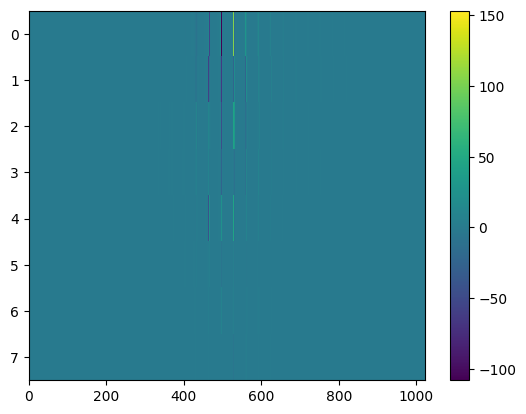

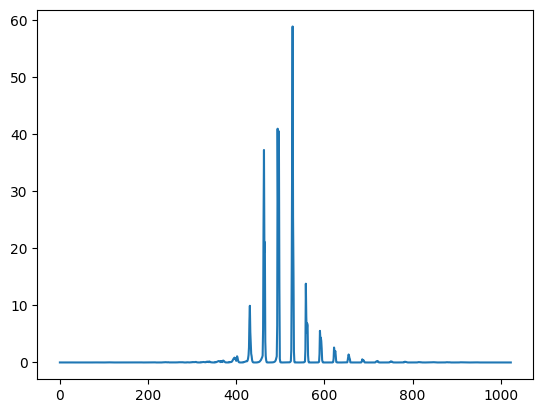

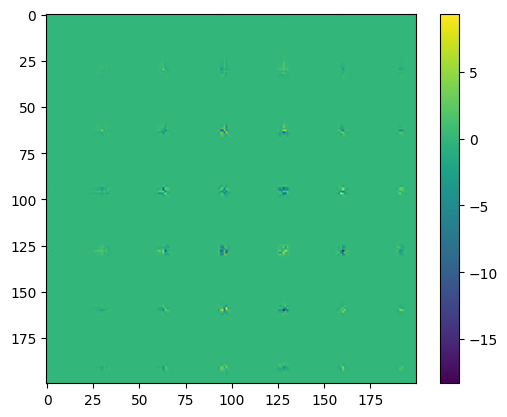

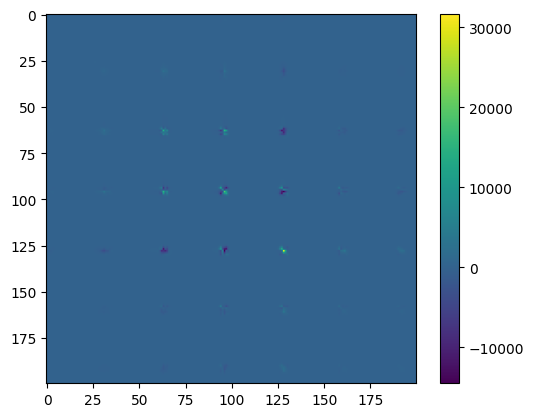

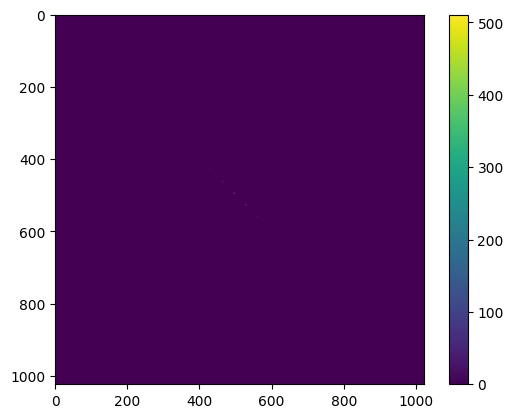

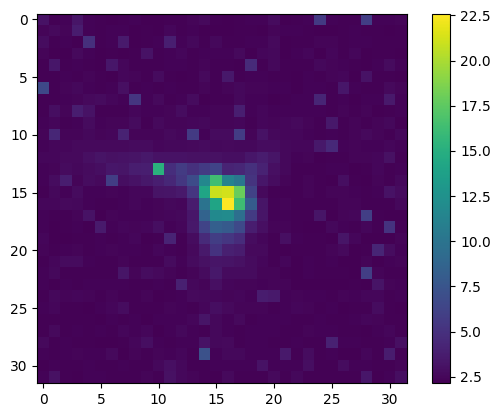

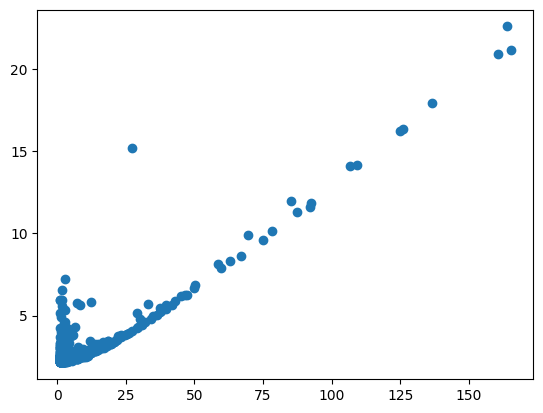

In [6]:
plt.figure()
plt.imshow(C_combined, aspect='auto', interpolation='none')
plt.colorbar()
plt.figure()
plt.plot(np.std(C_combined,0))
plt.figure()
plt.imshow((cov-Sigma_model)[400:600,400:600])
plt.colorbar()
plt.figure()
plt.imshow((cov)[400:600,400:600])
plt.colorbar()
plt.figure()
plt.imshow(Psi)
plt.colorbar()
plt.figure()
plt.imshow(np.sqrt(np.diag(Psi)).reshape(32,32))
plt.colorbar()

# plt.figure()
# mean_vals = np.nanmean(A_col,0)
# plt.scatter(np.sqrt(mean_vals), np.sqrt(np.diag(Psi)))

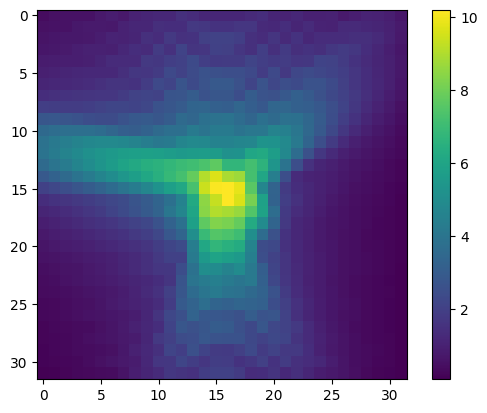

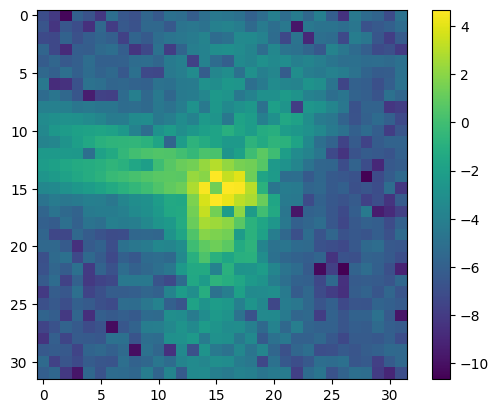

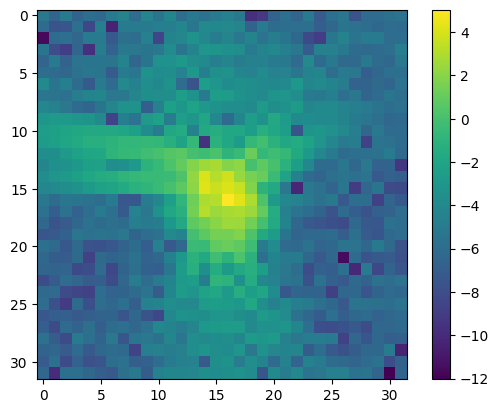

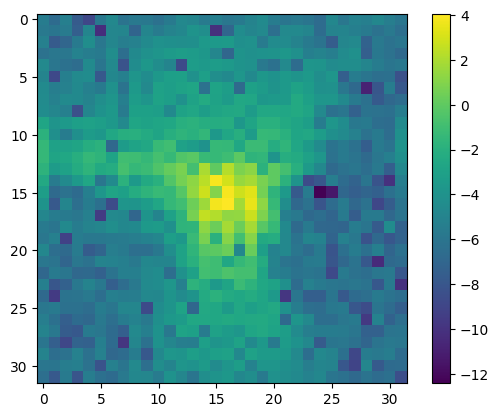

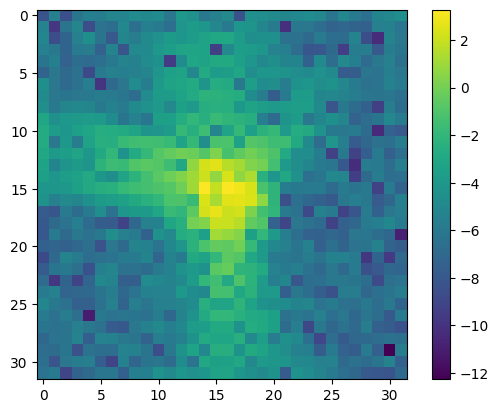

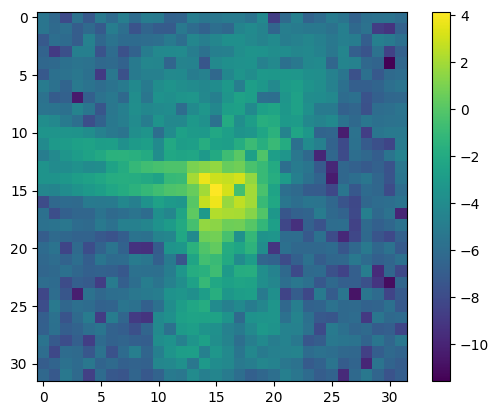

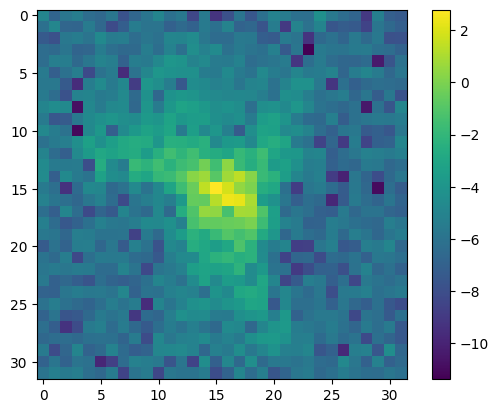

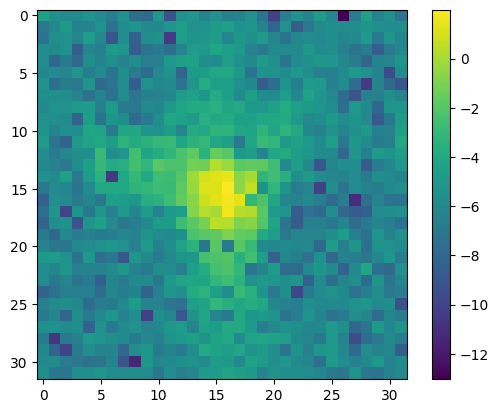

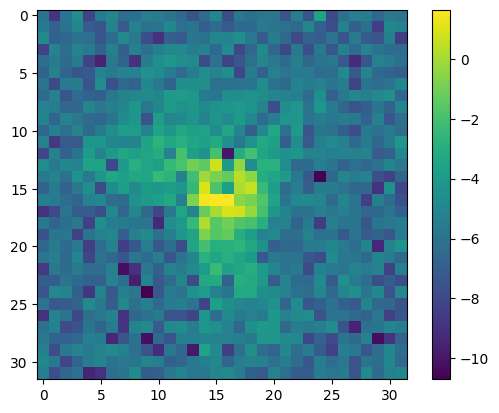

In [7]:
# plt.figure()
# plt.imshow(np.log(mean_vals).reshape(32,32))
# plt.colorbar()
for ii in range(C_combined.shape[0]):
    plt.figure()
    plt.imshow(np.log(np.abs(C_combined[ii,::])).reshape(32,32))
    plt.colorbar()

In [8]:
train_data = train_data
if False:
    def correct_FGS_jitter(data):

        design_matrix = cp.array(C_combined)[:,:]
        coeffs = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data.T, design_matrix.T, return_A_pinv_w=False)[0]
        data -= (design_matrix.T@coeffs).T

        return data


    R_row = np.memmap(kgs.temp_dir + 'FGS_row.memmap',  dtype=np.float32, mode='r', shape=(1350*len(train_data), 32*32), order='C')#[:50000,...]
    
    jitter_corrected_col = np.memmap(kgs.temp_dir + 'FGS_jitter_corrected_col.memmap',  dtype=np.float32, mode='w+', shape=(10*len(train_data), 32*32), order='F')#[:50000,...]

    data = []
    for ii in tqdm(range(len(train_data))):
        
        this_data_full = cp.array(R_row[1350*ii:1350*(ii+1),...], dtype=cp.float64).reshape(-1,32*32)
        
        this_data = cp.zeros((10,32*32))
        for iii in range(10):
            this_data[iii,...] = cp.mean(this_data_full[135*iii:135*(iii+1),...],0)
        #plt.figure()
        #plt.imshow(this_data[0,...].get())
        
        #plt.figure()
        #plt.imshow(this_data[0,...].get())
        #print(np.mean(this_data,0).shape)
        this_data = correct_FGS_jitter(this_data)
        #plt.figure()
        #plt.imshow(this_data[0,...].get())
        this_data = this_data - np.mean(this_data,0)
        jitter_corrected_col[10*ii:10*(ii+1),...] = this_data.get()
        #plt.figure()
        #plt.imshow(this_data[0,...].get())
        #plt.pause(0.001)
        if ii%20==0:
            jitter_corrected_col.flush()
    jitter_corrected_col.flush()

In [9]:
# jitter_corrected_col = np.memmap(kgs.temp_dir + 'FGS_jitter_corrected_col.memmap',  dtype=np.float32, mode='r', shape=(1350*len(train_data), 32*282), order='F').reshape(-1,32,282)
# import ariel_diagnostics
# ariel_diagnostics.animate_3d_matrix(jitter_corrected_col[::100,:,:])

In [10]:
if False:
    jitter_corrected_col = np.memmap(kgs.temp_dir + 'FGS_jitter_corrected_col.memmap',  dtype=np.float32, mode='r', shape=(10*len(train_data), 32*32), order='F')
    jitter_corrected_col = cp.array(jitter_corrected_col[...], dtype=cp.float64)

    C0_combined=ariel_numerics.nan_pca(jitter_corrected_col,1)[1]
    C0_combined = C0_combined*cp.sign(C0_combined[cp.argmax(cp.abs(C0_combined))])

    kgs.dill_save(kgs.calibration_dir + 'FGS_C0_2.pickle', (C0_combined))
    

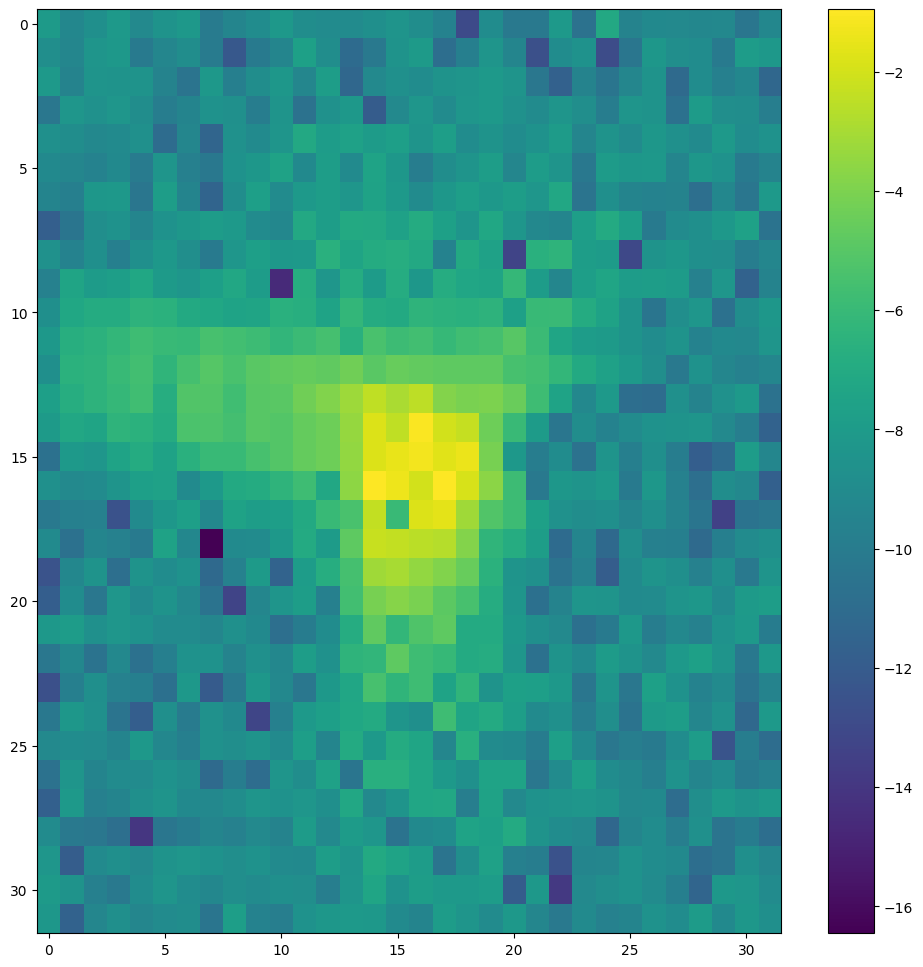

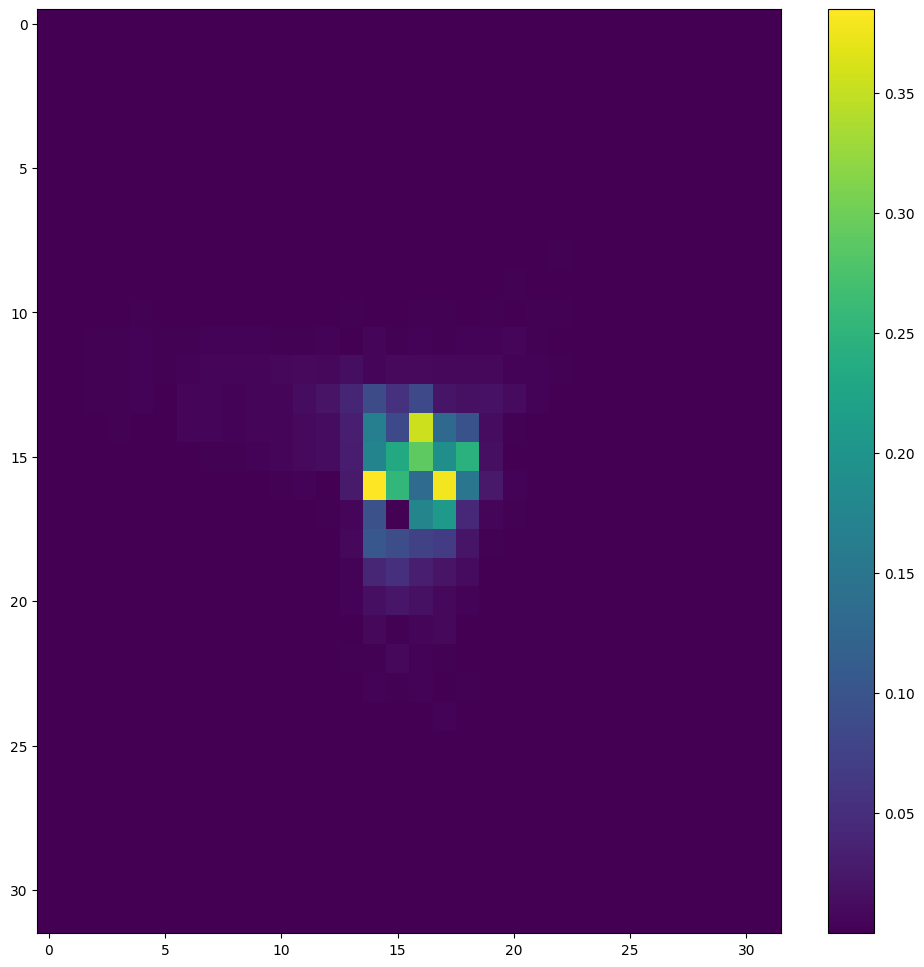

In [11]:
C0_combined = kgs.dill_load(kgs.calibration_dir + 'FGS_C0_2.pickle')
plt.figure(figsize=(12,12))
plt.imshow(cp.log(C0_combined).reshape(32,32).get(), aspect='auto', interpolation='none')
plt.colorbar()
plt.figure(figsize=(12,12))
plt.imshow(C0_combined.reshape(32,32).get(), aspect='auto', interpolation='none')
plt.colorbar()

In [12]:
import cupyx.scipy.sparse
import cupyx.scipy.sparse.linalg
import cupy as cp
N_components_use = 9
design_matrix_combined = cp.concatenate((C0_combined,cp.array(C_combined)))

In [13]:
importlib.reload(ariel_load)
M=1024
rows = 1025 * cp.arange(M, dtype=cp.int64)             # 0, 1025, 2050, ...
cols = N_components_use + cp.arange(M, dtype=cp.int64) # offset columns
dataa = cp.ones(M, dtype=cp.float32)
add_block = cupyx.scipy.sparse.csc_matrix((dataa, (rows, cols)), shape=(1024*1024, N_components_use+1024))

def get_coeffs(data):
    
    data = data.reshape(-1,1024)
        
    isnan = cp.isnan(data[0,:])
    #isnan = cp.zeros_like(isnan)

    detrended = ariel_numerics.remove_trend_cp(data)[10:-10,...]
    detrended[:,isnan]=0
    rhs = detrended.T@detrended/(detrended.shape[0]-1)
    #print(rhs)
    # plt.figure()
    # plt.imshow(detrended[0,...].get().reshape(32,32))
    # plt.colorbar()
    #rhs = ariel_numerics.estimate_noise_cov_cp(data)
    #rhs = cp.array(cov)
    
#     plt.figure()
#     plt.imshow(rhs[400:600,400:600].get())
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(cov[400:600,400:600])
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(rhs[400:600,400:600].get())
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(rhs[400:600,400:600].get()/cov[400:600,400:600])
#     plt.colorbar()

    #rhs[isnan,:] = 0
    #rhs[:,isnan] = 0

    rhs=rhs.flatten()
    
    # plt.figure()
    # plt.plot(rhs.get())
    
    design_matrix_noise = cupyx.scipy.sparse.csc_matrix((1024*1024, N_components_use+1024))    
    design_matrix_part = cp.zeros((1024*1024,N_components_use))
    for ii in range(N_components_use):
        x = copy.deepcopy(design_matrix_combined[[ii],:])
        x[:,isnan]=0
        x1 = (x.T@x).flatten()        
        design_matrix_part[:,ii] = x1
    design_matrix_noise[:,:N_components_use] = design_matrix_part

    # --- vectorized construction of the second-loop entries ---    
    design_matrix_noise += add_block
       # for ii in range(1024):
       #     design_matrix_noise[1025*ii,ii+N_components_use]=1

    #plt.figure()
    #plt.plot(design_matrix_noise.sum(0).T.get())

    #print((design_matrix_noise.T@design_matrix_noise).shape)
    coeffs = cp.linalg.solve((design_matrix_noise.T@design_matrix_noise).todense(), design_matrix_noise.T@rhs)
    #residual = rhs - design_matrix_noise*coeffs
    noise_est = cp.sqrt(coeffs[N_components_use:])
    noise_est[cp.isnan(noise_est) | (noise_est<1)] = 1
    
    # plt.figure()
    # plt.scatter(cp.sqrt(cp.abs(cp.mean(data,0))).get(), noise_est.get())
    # x=cp.sqrt(cp.abs(cp.mean(data,0))).get()
    # plt.scatter(x, np.sqrt(4+0.018*x**2))
    #plt.xlim([0,10])
    #plt.ylim([0,10])
    
#     plt.figure()
#     plt.scatter(2+cp.sqrt(cp.abs(cp.mean(data,0))).get(), noise_est.get())
    
# #     print(np.min(noise_est), np.max(noise_est), np.sum(np.isnan(noise_est)))
    
#     noise_est_naive = 2+cp.sqrt(design_matrix_combined[0,:])
    
#     plt.figure()
#     plt.scatter(noise_est_naive.get(), noise_est.get())
    
        
#     plt.figure()
#     plt.scatter(cp.sqrt(cp.abs(cp.mean(data,0))).get(), np.sqrt(np.diag(Psi)))
    
    # plt.figure()
    # plt.scatter(np.sqrt(np.diag(Psi)), noise_est.get(), )
    # plt.axline((0,0),slope=1/0.6, color='black')
    
#     plt.figure()
#     plt.imshow(noise_est.get().reshape(32,32))
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(noise_est.get().reshape(32,32)/np.sqrt(np.diag(Psi)).reshape(32,32))
#     plt.colorbar()
    
    noise_est_naive = cp.sqrt(4+0.018*cp.abs(cp.mean(data,0)))
    to_change = noise_est<noise_est_naive
    #print(cp.sum(to_change))
    noise_est[to_change] = noise_est_naive[to_change]
    
    # plt.figure()
    # plt.scatter(cp.sqrt(cp.abs(cp.mean(data,0))).get(), noise_est.get())
    # x=cp.sqrt(cp.abs(cp.mean(data,0))).get()
    #plt.scatter(x, np.sqrt(4+0.018*x**2))
    
    # plt.figure()
    # plt.scatter(np.sqrt(np.diag(Psi)), noise_est.get(), )
    # plt.axline((0,0),slope=1/0.6, color='black')

      

    mean_handled = False
    while True:

        if mean_handled:
            design_matrix = design_matrix_combined            
        else:
            design_matrix = cp.concatenate((design_matrix_combined, cp.ones((1,1024))))

        N = design_matrix.shape[0]

        res = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data.T, design_matrix.T, return_A_pinv_w=True, sigma=noise_est)
        coeffs = res[0]
        
        #print((design_matrix@design_matrix.T).shape)
        # plt.figure()
        # plt.imshow(res[1].get())
        # plt.colorbar()
        # plt.title('res[1]')
        # plt.figure()
        # plt.imshow((design_matrix@design_matrix.T).get())
        # plt.colorbar()
        # plt.figure()
        # plt.imshow(cp.log(cp.linalg.inv(design_matrix@design_matrix.T)).get())
        # plt.colorbar()
        # plt.figure()
        # plt.imshow((cp.log(design_matrix).get()), aspect='auto', interpolation='none')
        # plt.colorbar()
        # plt.figure()
        # plt.imshow(data.get())
        # plt.figure()
        # plt.plot(C0_combined.T.get())
        # plt.figure()
        # plt.plot(design_matrix[0,:].T.get())
        
        # plt.figure()
        # X = coeffs.T
        # X = X-cp.mean(X,0)
        # plt.plot(X.get())
        
        pred = design_matrix.T@coeffs
        residual = (data.T - pred).T

#         residualf[:,:,i_wavelength] = (data[:,:,i_wavelength].T - design_matrix.T@coeffs).T           #

#         #print(res[1].shape, cp.diag(noise_est**2).shape)
#         A_pinv_w = res[1]
#         A_pinv_w_full = cp.zeros((N,32))
#         A_pinv_w_full[:,~cp.isnan(data[0,:,i_wavelength])] = A_pinv_w
#         noise_est[cp.isnan(data[0,:,i_wavelength])] = 0
#         noise_output[i_wavelength] = cp.sqrt((A_pinv_w_full@cp.diag(noise_est**2)@A_pinv_w_full.T)[0,0])

#         noise_seen[i_wavelength] = ariel_numerics.estimate_noise_cp(coeffs[0,:])

# #             res2 = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data[:,:,i_wavelength].T, design_matrix[0:3,:].T, return_A_pinv_w=True, sigma=noise_est)

# #             A_pinv_w = res2[1]
# #             A_pinv_w_full = cp.zeros((3,32))
# #             A_pinv_w_full[:,~cp.isnan(data[0,:,i_wavelength])] = A_pinv_w
# #             noise_est[cp.isnan(data[0,:,i_wavelength])] = 0
# #             noise_no_jitter[i_wavelength] = cp.sqrt((A_pinv_w_full@cp.diag(noise_est**2)@A_pinv_w_full.T)[0,0])

#         mat = design_matrix.T@A_pinv_w_full
#         #print(mat.shape)
#         cov_expected = cp.diag(noise_est**2) - mat@cp.diag(noise_est**2)@mat.T
#         residual_expected[:,i_wavelength] = cp.sqrt(cp.diag(cov_expected))

#         residual_expected_ratio = cp.mean(residualf[:,:,i_wavelength],0)/residual_expected[:,i_wavelength]*np.sqrt(1350)
#         residual_expected_ratio[cp.isnan(residual_expected_ratio)] = 0

#         #if i_wavelength>200 and i_wavelength<220:
#         #    print(i_wavelength, residual_expected_ratio, cp.max(cp.abs(residual_expected_ratio)))
#         # if cp.max(cp.abs(residual_expected_ratio))==0:
        #     plt.figure()
        #     plt.imshow(cov_expected.get())
        #     plt.figure()
        #     #plt.plot(residual_expected[:,i_wavelength].get())
        #     plt.plot(cp.std(residualf[:,:,i_wavelength].get()))
        #     print(cp.std(residualf[:,:,i_wavelength].get()))
        #     raise 'stop'
        if False:#cp.any(cp.abs(residual_expected_ratio)>30):
            #print(i_wavelength, cp.max(cp.abs(residual_expected_ratio)), cp.argmax(cp.abs(residual_expected_ratio)), mean_handled)
            data[:,cp.argmax(cp.abs(residual_expected_ratio)),i_wavelength] = cp.nan
        else:
            #mean_handled = True
            if not mean_handled:
                #print(coeffs[3,:].shape)
                data-=np.mean(coeffs[-1,:])    
                #print(np.mean(coeffs[-1,:])  )  
                mean_handled = True
            else:
                break
    
#     plt.figure()
#     plt.imshow(cp.mean(residual,0).reshape(32,32).get())
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(cp.std(residual,0).reshape(32,32).get())
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow((cp.mean(residual,0)/(cp.std(residual,0))).reshape(32,32).get())
#     plt.colorbar()


    return (coeffs,cp.sum(pred,0))

if False:
    kgs.profiling=True
    R_row = np.memmap(kgs.temp_dir + 'FGS_row.memmap',  dtype=np.float32, mode='r', shape=(1350*len(train_data), 32*32), order='C')#[:50000,...]
    all_coeffs =[]
    importlib.reload(ariel_load)
    for ii in tqdm(range(len(train_data))):
        
        data = cp.array(R_row[1350*ii:1350*(ii+1),...], dtype=cp.float64)
        res = get_coeffs(data)
        all_coeffs.append(res)
        
#         d = copy.deepcopy(train_data[ii])
#         loaders = ariel_load.default_loaders()
#         loaders[0].cache_steps = []
#         #for iii in range(2):
#         #    loaders[iii].apply_pixel_corrections.mask_hot=False
#         #loaders[1].apply_full_sensor_corrections.inpainting_2d = False
#         #loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = True
#         #loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
#         d.load_to_step(5,loaders)
#         data = d.transits[0].data[0].data
#         #plt.figure()
        #plt.plot(data.get())
        
       # # plt.figure()        
       #  x = res[0][0,:].get()
       #  #x = res[1].get()
       #  pred_new = x/kgs.rms(x)
       # # plt.plot(pred_new)
       #  x = data.get().flatten()
       #  pred_orig = x/kgs.rms(x)
       #  # plt.plot(pred_orig)
       #  # plt.figure()
       #  # plt.plot(pred_orig-pred_new)
        # plt.pause(0.001)
        plt.pause(0.001)
        #print(ariel_numerics.estimate_noise_cp(pred_orig), ariel_numerics.estimate_noise_cp(pred_new))
        
        
    #all_coeffs = cp.concatenate([c.T for c in all_coeffs])
    #all_coeffs.shape
    kgs.dill_save(kgs.temp_dir + 'FGS_coeffs.pickle', all_coeffs)
    
all_coeffs = kgs.dill_load(kgs.temp_dir + 'FGS_coeffs.pickle')
all_coeffs = cp.concatenate([c[0].T for c in all_coeffs])
all_coeffs.shape

(1483650, 9)

In [14]:
kgs.debugging_mode = 1
kgs.profiling=False
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = True
model.train(train_data)

In [16]:
if False:
    loaded_res = kgs.dill_load(kgs.temp_dir + '/prep.pickle')
    model.infer(train_data[0:1]);
    transits = []
    for d,r in tqdm(zip(train_data,loaded_res)):
        mm= copy.deepcopy(model.results['model_mean'])
        mm= copy.deepcopy(model.results['model_mean'])
        mm.m['signal'].m['main'].m['transit'].transit_params[0][0] = d.transit_params
        mm.m['signal'].m['main'].m['transit'].transit_params[0][0].u = [0,0]
        mm.m['signal'].m['main'].m['transit'].transit_params[0][1] = d.transit_params
        mm.m['signal'].m['main'].m['transit'].transit_params[0][1].u = [0,0]
        mm.set_parameters(r[0])
        mm.m['signal'].m['main'].m['transit'].depth_model.offset = -d.diagnostics['training_spectrum']    
        obs_transit = copy.deepcopy(model.results['obs'])

        stellar_labels = mm.m['signal'].m['main'].m['spectrum'].get_prediction(obs_transit)
        transit_labels = mm.m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        obs_transit.labels = stellar_labels*transit_labels
        #obs_transit.labels = model.results['model_mean'].m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        #obs_transit.labels = mm.m['signal'].m['main'].get_prediction(obs_transit)
        #obs_transit.labels = mm.m['signal'].get_prediction(obs_transit)
        #print(mm.m['signal'].m['main'].m['transit'].get_parameters())
        #d.diagnostics['transit'] = obs_transit
        transits.append(obs_transit.export_matrix(False))
    del loaded_res
    del mm
    del model
    transits = cp.array(np.concatenate(transits))
    kgs.dill_save(kgs.temp_dir + 'FGS_transits.pickle', transits)
    
transits = kgs.dill_load(kgs.temp_dir + 'FGS_transits.pickle')
transits.shape

(1483650, 1)

In [44]:
import scipy
N=1099
#train_data = kgs.load_all_train_data()[:N]
order = 4
design_matrix_base = scipy.sparse.lil_matrix((1350*len(train_data), order*len(train_data)))
#design_matrix_base = np.zeros((1350*len(train_data), 4*len(train_data)))
x = np.arange(1350)
x_norm = 2*(x - x.min())/(x.max() - x.min()) - 1
for ii in range(len(train_data)):
    for i_order in range(order):
        coeffs = np.zeros(order)
        coeffs[i_order]=1
        design_matrix_base[1350*ii:1350*(ii+1), order*ii+i_order] = np.polynomial.chebyshev.chebval(x_norm, coeffs)
design_matrix_base = design_matrix_base.tocsr()

design_matrix_fit = design_matrix_base[:1350,:order].todense()

In [45]:
rr=[]
f = np.zeros((N_components_use-1,N_components_use))
e = np.zeros((1350*len(train_data),N_components_use-1))
r = np.zeros((1,N_components_use))
r[0] = 1
poly_coeffs = np.zeros(order*len(train_data))
poly_coeffs[::order] = 1
t = transits[:1350*N,:].get()
w = all_coeffs[:1350*N,:].get()

def calc_residual():
    #print(r.shape, (design_matrix_base@poly_coeffs).shape, t.shape)
    val = r* (design_matrix_base@poly_coeffs)[:,None] * t + e@f
    residual = w-val
    #plt.figure()
    #plt.plot((residual[29*1350:30*1350,:]))
    #plt.pause(0.001)
    return residual
    #print(val.shape)

for i_iter in tqdm(range(10)):

   # print('st', kgs.rms(calc_residual()))
    

    # update r   
    y = w - e@f
    x = (design_matrix_base@poly_coeffs)[:,None] * t
    x = x.flatten()
    for ii in range(r.shape[1]):

        #print(x.shape,y.shape)
        r[0,ii] = np.sum(x*y[:,ii])/np.sum(x*x)

    #print(r)
   # print('r', kgs.rms(calc_residual()))
    
    

    # update polynomial
    yf = w - e@f
    xf = r*t
    for ii in range(N):
        y = yf[1350*ii:1350*(ii+1),:].T.flatten()
        x = xf[1350*ii:1350*(ii+1),:].T.flatten()
        coeffs = np.linalg.lstsq(np.array(np.concatenate([design_matrix_fit]*N_components_use))*x[:,None], y, rcond=None)[0]
        poly_coeffs[order*ii:order*(ii+1)]= coeffs

  #  print('p', kgs.rms(calc_residual()))
    

    # if i_iter%10==0:
    #     residual = calc_residual()
    #     plt.figure()
    #     plt.plot((residual[29*1350:30*1350,:]))
    #     plt.pause(0.001)

    y = w - r * (design_matrix_base@poly_coeffs)[:,None] * t

    from sklearn.decomposition import PCA
    pca = PCA(n_components=N_components_use-1)
    pca.fit(y)
    f = pca.components_          # Principal directions (eigenvectors)
    e = pca.transform(y)
    #print(f.shape, e.shape)
    #f = np.array([[0,1,0],[0,0,1]], dtype=np.float64)
    #e = y[:,1:]        
    #print(f.shape, e.shape)

    explain_matrix = np.concatenate([r,f])

    #print(explain_matrix)

    matrix_inv = np.linalg.inv(explain_matrix.T)
    apply_weights = matrix_inv[0,:]

   # print(i_iter, apply_weights/kgs.rms(apply_weights), kgs.rms(calc_residual()))

    #print('f', kgs.rms(calc_residual()))
    
print(apply_weights)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]

[ 1.48877897e+00 -4.41130968e+03  5.15984429e+01  1.03482896e+03
 -9.57907437e+01  6.71956235e+01  6.42875670e+01  8.61059182e+01
 -1.43921743e+02]


In [46]:
#plt.plot(pca.explained_variance_ )

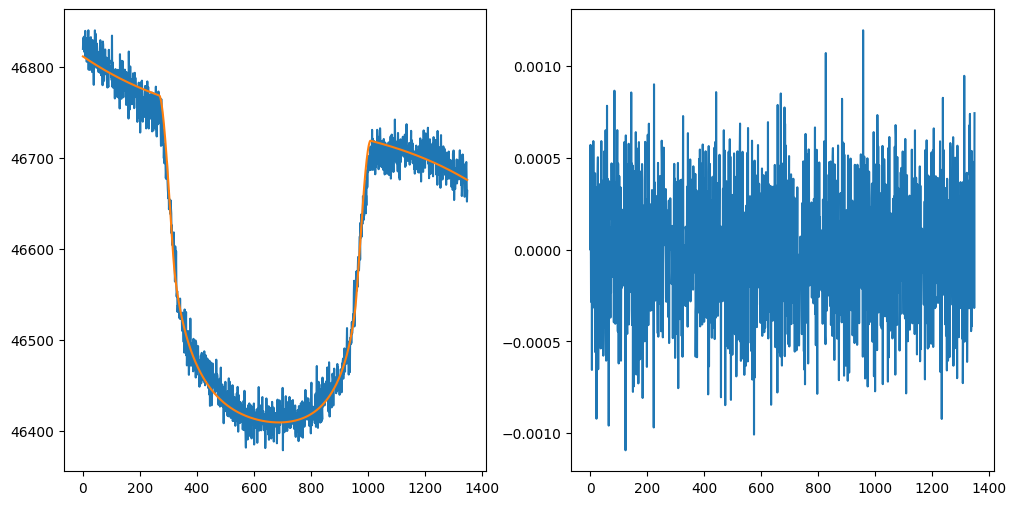

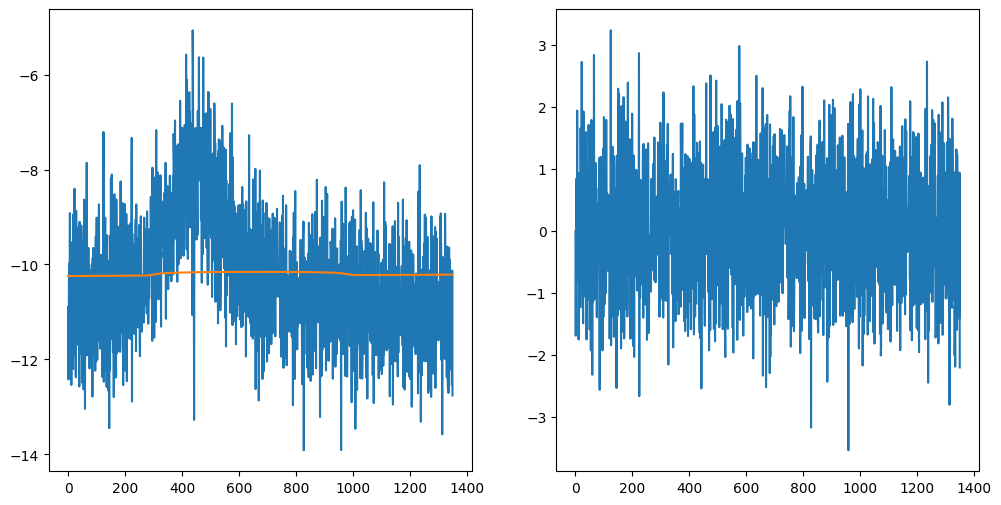

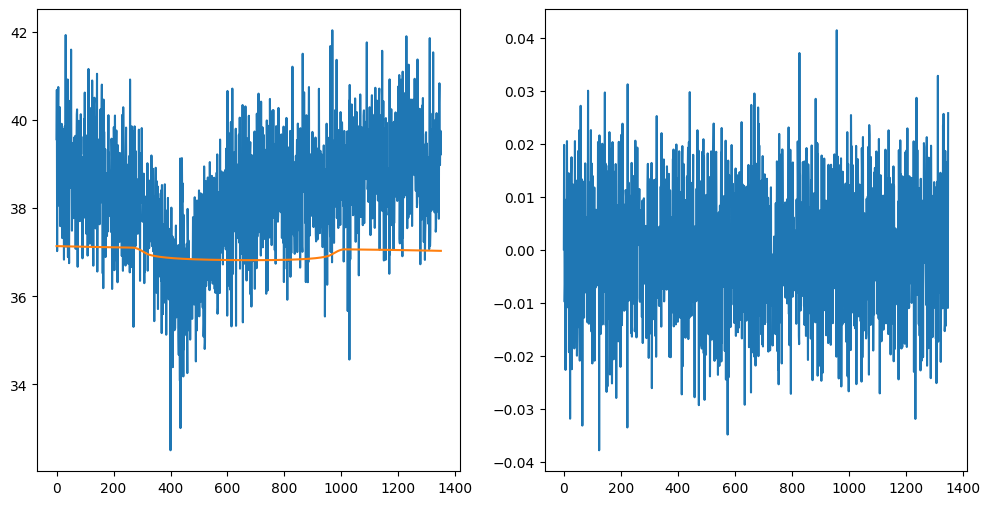

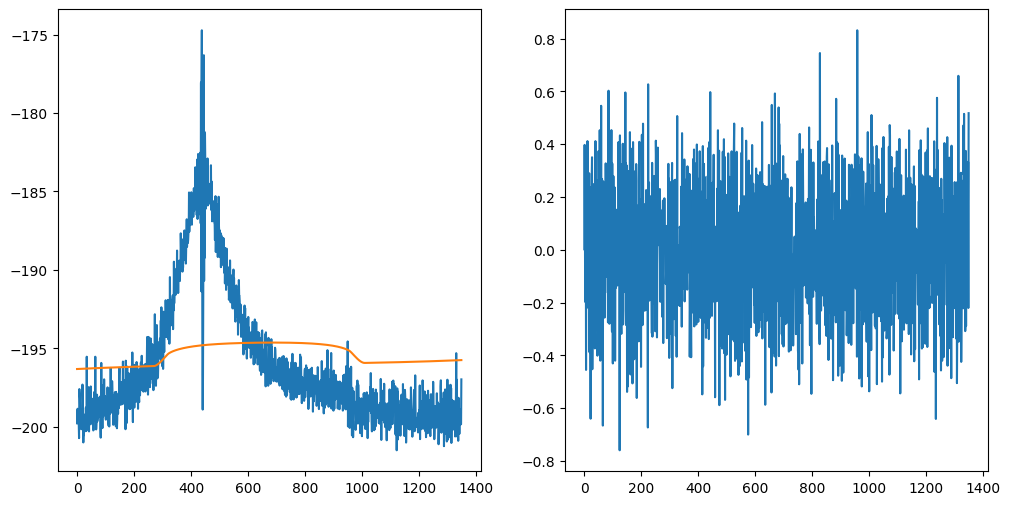

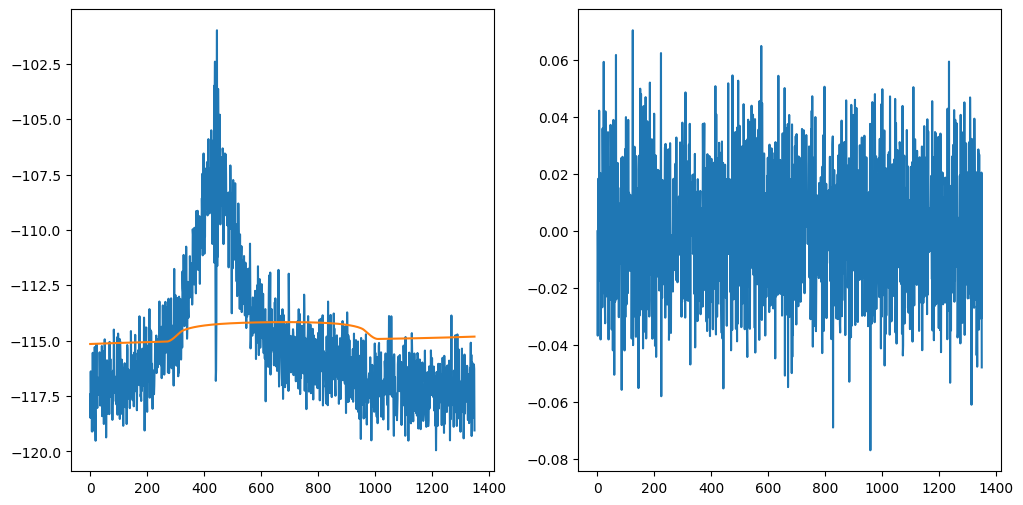

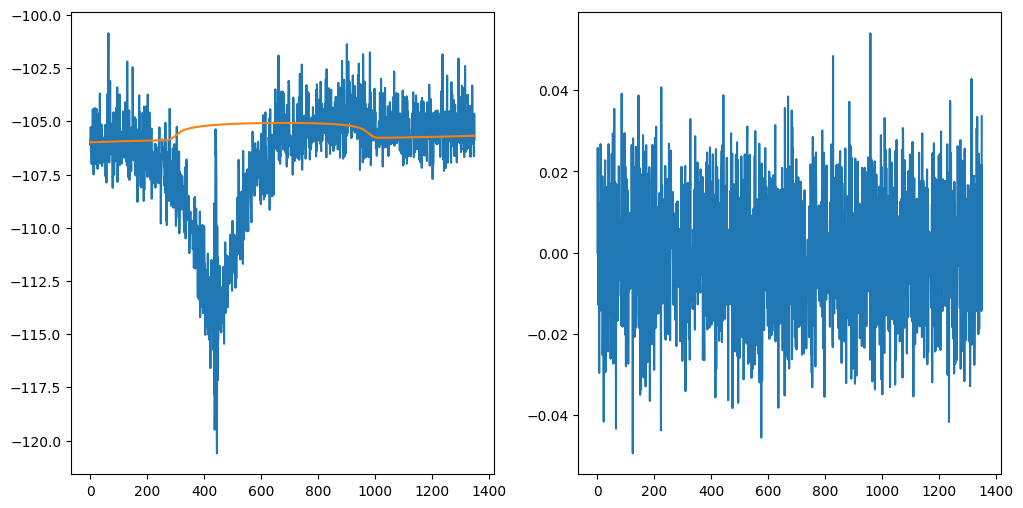

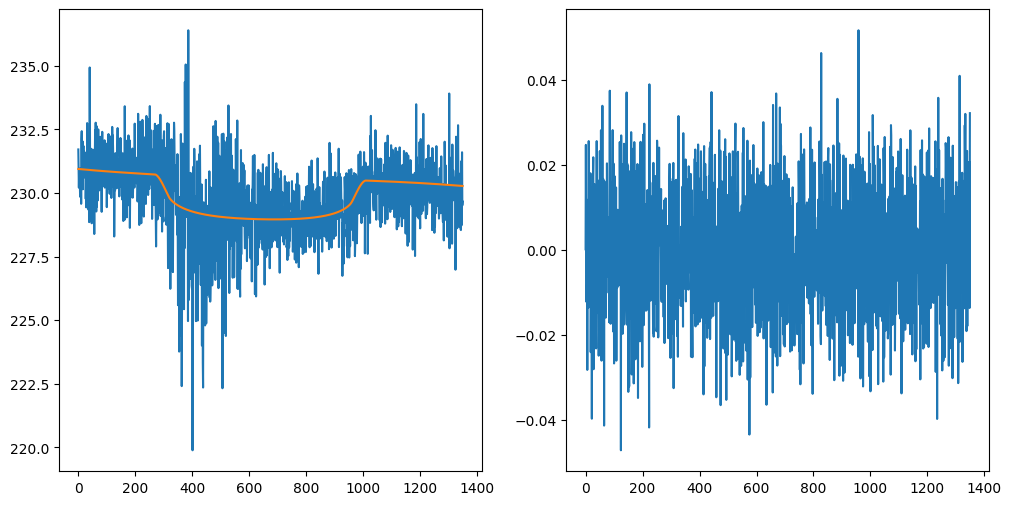

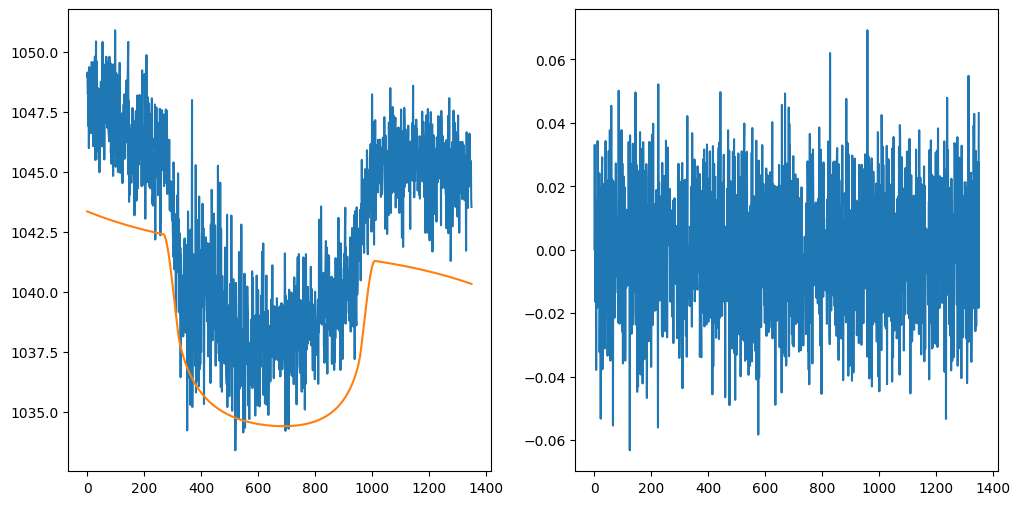

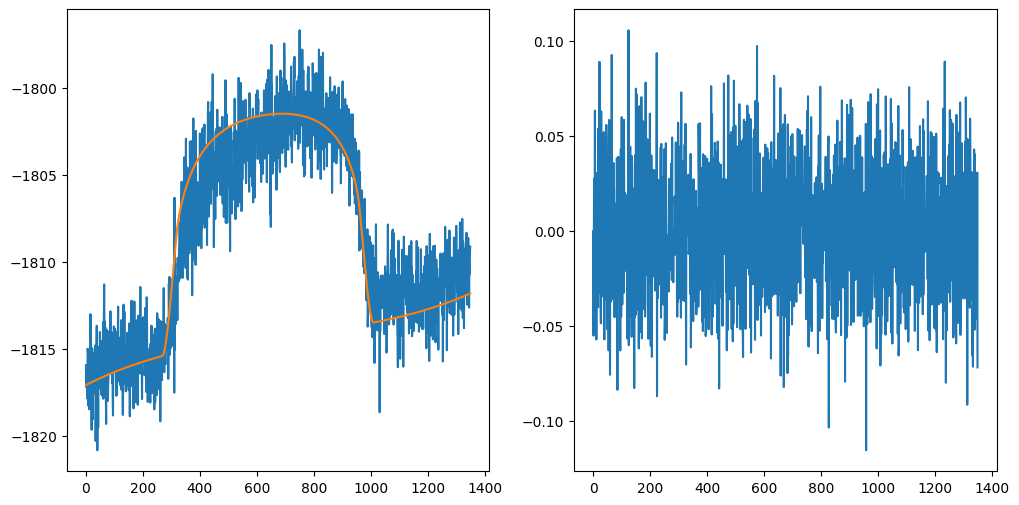

In [47]:
slic = slice(1350*29,1350*30)
for ii in range(N_components_use):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0])
    plt.plot(w[slic,ii])
    plt.plot((r[0,ii]*(design_matrix_base@poly_coeffs)[:,None]*t)[slic,:])
    
    plt.sca(ax[1])
    residual = calc_residual()
    plt.plot(residual[slic,ii])
    #plt.plot(e[slic,ii])
    


In [29]:
# residual_part = w- r* (design_matrix_base@poly_coeffs)[:,None] * t
# cov = residual_part.T@residual_part
# plt.figure()
# plt.imshow(cov)
# plt.colorbar()
# plt.figure()
# plt.imshow(cov/np.sqrt(np.outer(np.diag(cov),np.diag(cov))))
# plt.colorbar()

In [30]:
# plt.figure()
# plt.plot(np.sum(apply_weights*w[slic,:],1))
# plt.plot(((design_matrix_base@poly_coeffs)[:,None]*t)[slic,:])

In [31]:
# np.sum(apply_weights*w[slic,:],1).shape

In [32]:
# P = np.linalg.inv(cov)
# #plt.figure()
# #plt.imshow(np.log(np.abs(P)))
# #plt.colorbar()
# print ( ((r@P)/(r@P@r.T)).T )
# pred = ((r@P@w.T)/(r@P@r.T)).T
# print(1/r[0,0])
# tt = ((design_matrix_base@poly_coeffs)[:,None]*t)[slic,:]
# plt.figure()
# plt.plot(pred[slic])
# plt.plot(tt)
# plt.title(str(ariel_numerics.estimate_noise_cp(cp.array(pred[slic])).get()) + ' ' + str(kgs.rms(pred[slic]-tt)))
# plt.figure()
# y_attempt = w[:,0][slic]/r[0,0]#-w[:,3][slic]
# plt.plot(y_attempt)
# plt.plot(((design_matrix_base@poly_coeffs)[:,None]*t)[slic,:])
# plt.title(str(ariel_numerics.estimate_noise_cp(cp.array(y_attempt))) + ' ' + str(kgs.rms(y_attempt-tt.T)))



19.94343652091445


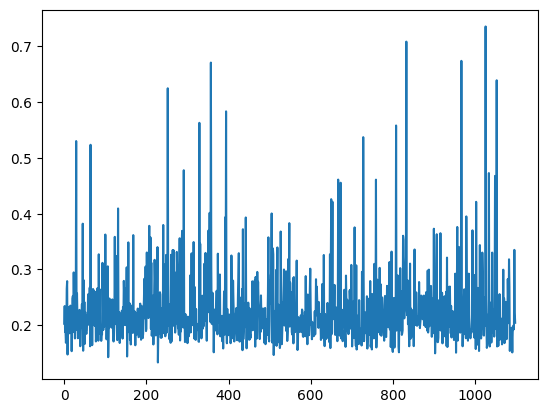

17.802752742594986
[  6.06161182  -0.89685453  -1.57705645   2.70833524  -0.81795529
   3.01065449   6.53662325 -11.93218074  16.37146265]


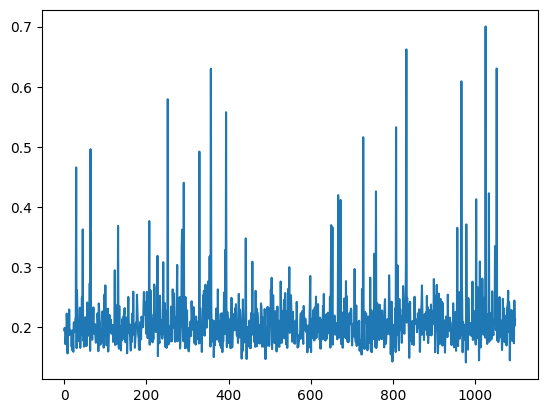

15.13160100302944
[  6.06161182  -1.26225138  -1.49378687   2.30986778  -0.87824608
   2.583951     6.06301123 -10.52901774  14.86668065]


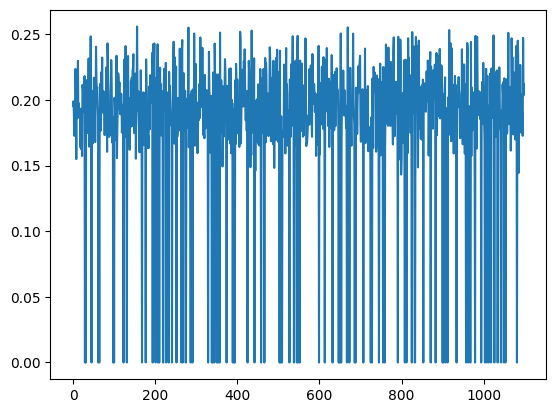

In [48]:
N=1099
ws=100
deg=4
target = cp.array(transits)
target_lf = copy.deepcopy(target)
for ii in range(N):
    target_lf[1350*ii:1350*(ii+1)] -= ariel_numerics.remove_trend_cp(target[1350*ii:1350*(ii+1)], window_size=ws, degree=deg)
all_coeffs_lf = copy.deepcopy(all_coeffs)
for ii in range(N):
    all_coeffs_lf[1350*ii:1350*(ii+1),:] -= ariel_numerics.remove_trend_cp(all_coeffs_lf[1350*ii:1350*(ii+1),:], window_size=ws, degree=deg)
design_matrix_fit_cp = cp.array(design_matrix_fit)
ratio_list = None
def f(p, diags = False):
    p = copy.deepcopy(p)
    p[0] = 1/r[0,0]
    cost = 0
    global ratio_list
    ratio_list = []
    for ii in range(N):
        if not do_which[ii]:
            ratio_list.append(cp.array(0))
            continue
        pred = cp.sum(cp.array(p)*all_coeffs[1350*ii:1350*(ii+1),:],1)
        #pred_lf = pred - ariel_numerics.remove_trend_cp(pred, window_size=ws, degree=deg)
        pred_lf = cp.sum(cp.array(p)*all_coeffs_lf[1350*ii:1350*(ii+1),:],1)
        this_target =target[1350*ii:1350*(ii+1)]
        this_target_lf = target_lf[1350*ii:1350*(ii+1)]
        #this_target_lf = this_target - ariel_numerics.remove_trend_cp(this_target, window_size=ws, degree=deg)
        
        design_matrix = design_matrix_fit_cp*this_target_lf
        coeffs = cp.linalg.solve(design_matrix.T@design_matrix, design_matrix.T@pred_lf)
        this_target_lf = design_matrix@coeffs
        this_target = (design_matrix_fit_cp*this_target)@coeffs        
#         if diags:# and ii==2:
#             #pred = pred - ariel_numerics.remove_trend_cp(pred)
#             #this_target = this_target - ariel_numerics.remove_trend_cp(this_target)
#             plt.figure()
#             plt.plot(pred_lf.get())#-this_target_lf.get())
#             plt.plot(this_target_lf.get())
#             plt.title(ii)
            
# #             plt.figure()
# #             plt.plot(pred.get())
# #             plt.plot(this_target.get())
# #             plt.title(ii)
            
#             plt.figure()
#             plt.plot(w[1350*ii:1350*(ii+1),3])
#             plt.plot(w[1350*ii:1350*(ii+1),5])
            
        this_cost = kgs.rms(pred_lf-this_target_lf)
        
        
        ratio_list.append(this_cost/kgs.rms(pred-this_target))
        cost += this_cost.get()/N
    
    ratio_list = cp.array(ratio_list).get()
    #print(cost)
    return cost
do_which = [True]*N
p0 = np.zeros(N_components_use)
p0[0] = 1/r[0,0]
print(f(p0, diags=True))
plt.figure()
plt.plot(ratio_list)
plt.pause(0.001)
res=scipy.optimize.minimize(f,p0)
res.x[0] = 1/r[0,0]
print(f(res.x, diags=True))
print(res.x)
plt.figure()
plt.plot(ratio_list)
plt.pause(0.001)
do_which = ratio_list<0.25
res=scipy.optimize.minimize(f,res.x)
res.x[0] = 1/r[0,0]
print(f(res.x, diags=True))
print(res.x)
plt.figure()
plt.plot(ratio_list)
kgs.dill_save(kgs.calibration_dir + '/FGS_weights.pickle', res.x)

In [49]:
import subprocess

# Hibernate Windows
subprocess.run(
    ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
    check=True
)

CompletedProcess(args=['/mnt/c/Windows/System32/shutdown.exe', '/h'], returncode=0)